<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [137]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import spacy
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_lg")


## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [7]:
df = pd.read_csv('data/job_listings.csv',usecols=['description', 'title'])

In [74]:
df.head()
STOPWORDS = set(stopwords.words('english'))

def clean_text(X):
    """
        customized cleaning function
        X: series
    
        return: np.array
    """
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    number = re.compile('[0-9]+\s')  #remove freestanding numbers

    X = X.map(lambda t : t.lower()) # lwercase text
    X = X.map(lambda t : re.sub("\\\\n", ' ', t))
    X = X.map(lambda t : re.sub("\\\\x..", '',t))   
    X = X.map(lambda t : re.sub("^b[\'\"]", '',t))   
    X = X.map(lambda t : BeautifulSoup(t, "lxml").text) # strip html tags
    X = X.map(lambda t : REPLACE_BY_SPACE_RE.sub(' ', t))  # symbols by space in text
    X = X.map(lambda t : BAD_SYMBOLS_RE.sub('', t)) # delete symbols which are in BAD_SYMBOLS_RE
    X = X.map(lambda t : number.sub('', t))         # remove groups of digits
    X = X.map(lambda t : ' '.join(word for word in t.split() if word not in STOPWORDS))# delete stopwords
    return np.array(X)


In [125]:
STOPWORDS.update(['data','scientist', 'science','job', 'bjob', 'b'])
df['cleaned'] = clean_text(df.description)
df.head(10)

,description,title,cleaned,tokens
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,requirements conceptual understanding machine ...,"(requirements, conceptual, understanding, mach..."
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,description help us build machine learning mod...,"(description, help, us, build, machine, learni..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,working consulting side business responsible a...,"(working, consulting, side, business, responsi..."
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,monthcontractunder general supervision profess...,"(monthcontractunder, general, supervision, pro..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,location usa multiple locations 2+ years analy...,"(location, usa, multiple, locations, 2, +, yea..."
5,b'<div>Create various Business Intelligence An...,Data Scientist,create various business intelligence analytica...,"(create, various, business, intelligence, anal..."
6,b'<div><p>As Spotify Premium swells to over 96...,Associate Data Scientist – Premium Analytics,spotify premium swells 96m subscribers around ...,"(spotify, premium, swells, 96, m, subscribers,..."
7,"b""Everytown for Gun Safety, the nation's large...",Data Scientist,everytown gun safety nations largest gun viole...,"(everytown, gun, safety, nations, largest, gun..."
8,"b""<ul><li>MS in a quantitative discipline such...",Sr. Data Scientist,ms quantitative discipline statistics mathemat...,"(ms, quantitative, discipline, statistics, mat..."
9,b'<div><p>Slack is hiring experienced data sci...,"Data Scientist, Lifecyle",slack hiring experienced scientists join lifec...,"(slack, hiring, experienced, scientists, join,..."


In [126]:
df.title.value_counts()


Data Scientist                                                                     150
Senior Data Scientist                                                               14
Junior Data Scientist                                                               10
Associate Data Scientist                                                             8
Data Scientist Intern                                                                7
                                                                                  ... 
2019 PhD University Graduate - Data Scientist I/II - Applied Behavioral Science      1
2019 PhD University Graduate - Data Scientist I/II - Experimentation                 1
Sr. Data Scientist – Data for Insights Practice                                      1
People Data Scientist                                                                1
Data Analyst / Data Scientist                                                        1
Name: title, Length: 177, dtype: int64

## 2) Use Spacy to tokenize the listings 

In [127]:
##### Your Code Here #####
df['tokens'] = df['cleaned'].map(nlp)

df.shape

(426, 4)

In [128]:
type(df.tokens.array[0])

spacy.tokens.doc.Doc

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [129]:
##### Your Code Here #####
countvec = CountVectorizer(stop_words=list(STOPWORDS))   
word_vec = countvec.fit_transform(df.cleaned)
word_vec.shape

(426, 9558)

In [130]:
#countvec.vocabulary_
wc_df = pd.DataFrame(word_vec.todense(), columns=countvec.get_feature_names())


In [131]:
wc_df.head()

,00,000,000125,02,02115,03,030,030547069,04,062,...,zfs,zheng,zillow,zillows,zogsports,zones,zoom,zuckerberg,zurich,zurichs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

/home/dliu/.conda/envs/U4-S1-NLP/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

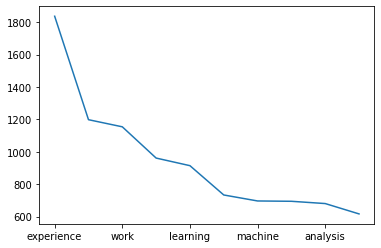

In [135]:
##### Your Code Here #####
wc_df.sum().sort_values(ascending=False).head(10).plot()



## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [182]:
##### Your Code Here #####

tf_vectorizer = TfidfVectorizer(stop_words=list(STOPWORDS))   
tf_vec = tf_vectorizer.fit_transform(df.cleaned)


# Get feature names to use as dataframe column headers
dliu = pd.DataFrame(tf_vec.todense(), columns=tf_vectorizer.get_feature_names())


# View Feature Matrix as DataFrame
print(dliu.shape)
dliu.sort_values('zheng', ascending=False).head()

(426, 9558)


,00,000,000125,02,02115,03,030,030547069,04,062,...,zfs,zheng,zillow,zillows,zogsports,zones,zoom,zuckerberg,zurich,zurichs
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [193]:
##### Your Code Here #####
ideal_job = (f"Are you the next Chief Data Officer at shape.ly silicon valley new  VC darling, according to pitchbook.com? expect to be touted"
            " are you a big data visionary with strong leadership and demonstrated ability to lead a growing team of brilliant data scientists and engineers" 
            " as we scale our team to infinity and our revenues to the moon. Don't worry about the fact that we have got a plan to make profit, we are well funded"
            " and our generous options package with and liberal policies will allow you to pivot our way to another startup success story. You should have a number of "
            "academic or industry credentials commensurate with your astronomical compensation package, and of course you should posess the right optics for such an public"
            "role in our next chapter")

nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dliu)

xp = tf_vectorizer.transform([ideal_job])
xpdf = pd.DataFrame(xp.todense(), columns=tf_vectorizer.get_feature_names())

listings =nn.kneighbors(xpdf, 3)[1]   #indices of 3 nearest neighbs
[df.iloc[x] for x in listings]

bestmatch =  df.iloc[212][0]
bestmatch = re.sub("\\\\n", ' ', bestmatch)
bestmatch = re.sub("\\\\x..", '',bestmatch)
bestmatch = re.sub("^b[\'\"]", '',bestmatch) 


In [195]:
from IPython.core.display import display, HTML
display(HTML(f"{bestmatch}"))

In [145]:
ideal_job


"Are you the next Chief Data Officer at shape.ly silicon valley new  VC darling, according to pitchbook.com? expect to be touted are you a big data visionary with strong leadership and demonstrated ability to lead a growing team of brilliant data scientists and engineers as we scale our team to infinity and our revenues to the moon. Don't worry about the fact that we have got a plan to make profit, we are well funded and our generous options package with and liberal policies will allow you to pivot our way to another startup success story. You should have a number of academic or industry credentials commensurate with your astronomical compesation package, and of course you should possess the right optics for such an publicrole in our next chapter"

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 